In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Conv2D, Convolution2DTranspose, MaxPooling2D, UpSampling2D, LeakyReLU, BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose, MaxPooling2D, UpSampling2D, LeakyReLU, Flatten, Dense, Reshape
from tensorflow.keras.activations import relu
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [7]:
# load cifar10 dataset
(_, _), (x_val, y_val) = cifar10.load_data()

In [8]:
# batch size
batch_size = 100

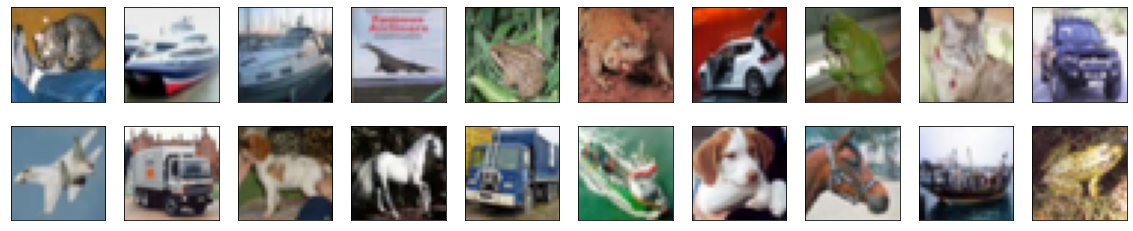

In [9]:
# show some training images
fig = plt.figure(figsize = (20, 4))

for idx in range(20):
  ax = fig.add_subplot(2, 10, idx + 1, xticks = [], yticks = [])
  plt.imshow(x_val[idx], cmap = 'gray')

In [10]:
x_val = x_val[:1000]
y_val = y_val[:1000]

In [11]:
print("Number of Validation Samples: ", len(x_val))

Number of Validation Samples:  1000


In [12]:
# shape of images
print("Shape of Validation images: ", x_val.shape)

Shape of Validation images:  (1000, 32, 32, 3)


In [13]:
# change data type
x_val = x_val.astype('float32')

In [14]:
# normalize data into range 1-0
x_val /= 255.0

In [15]:
print("Validation shape: ", x_val.shape)

Validation shape:  (1000, 32, 32, 3)


In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
import pickle
fgsm_test = open('./drive/My Drive/PhD_Thesis/adversarial_noise/cifar10/cifar10_fgsm_0.045_test.pickle', 'rb')
fgsm_noise_test = pickle.load(fgsm_test)

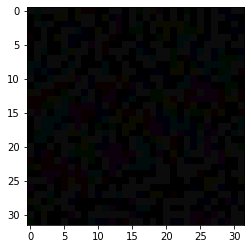

In [18]:
fgsm_noise_test.shape
plt.imshow(fgsm_noise_test[0])

In [19]:
x_val_noise = x_val + fgsm_noise_test[:1000]
x_val_noise.shape

(1000, 32, 32, 3)

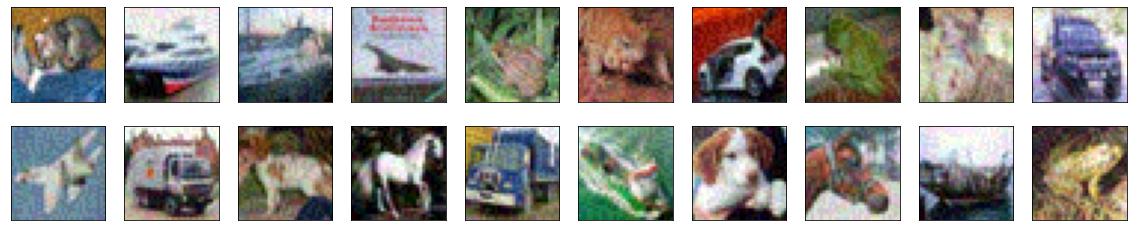

In [20]:
# show some training images
fig = plt.figure(figsize = (20, 4))

for idx in range(20):
  ax = fig.add_subplot(2, 10, idx + 1, xticks = [], yticks = [])
  plt.imshow(np.clip(x_val_noise[idx], 0, 1), cmap = 'gray')

In [57]:
# define encoder
  
inputs = layers.Input(shape = [32, 32, 3])
x = inputs

x = Conv2D(filters = 128, kernel_size = (3, 3), strides = 2, padding = 'same', activation = relu)(x)
x = BatchNormalization()(x)
  
x = Conv2D(filters = 256, kernel_size = (3, 3), strides = 2, padding = 'same', activation = relu)(x)
x = BatchNormalization()(x)

x = Conv2D(filters = 512, kernel_size = (3, 3), strides = 2, padding = 'same', activation = relu)(x)
x = Conv2D(filters = 512, kernel_size = (3, 3), strides = 1, padding = 'same', activation = relu)(x)
x = BatchNormalization()(x)

x = Conv2D(filters = 1024, kernel_size = (3, 3), strides = 2, padding = 'same', activation = relu)(x)
x = Conv2D(filters = 1024, kernel_size = (3, 3), strides = 1, padding = 'same', activation = relu)(x)
x = BatchNormalization()(x)

x = Flatten()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = Dense(units = 4096, activation = relu)(x)

# decoder
x = Reshape((2, 2, 1024))(x)
x = Conv2DTranspose(filters = 1024, kernel_size = (3, 3), strides = 2, padding = 'same', activation = relu)(x)
x = Conv2D(filters = 1024, kernel_size = (3, 3), strides = 1, padding = 'same', activation = relu)(x)
x = BatchNormalization()(x)

x = Conv2DTranspose(filters = 512, kernel_size = (3, 3), strides = 2, padding = 'same', activation = relu)(x)
x = Conv2D(filters = 512, kernel_size = (3, 3), strides = 1, padding = 'same', activation = relu)(x)
x = BatchNormalization()(x)

x = Conv2DTranspose(filters = 256, kernel_size = (3, 3), strides = 2, padding = 'same', activation = relu)(x)
x = Conv2D(filters = 256, kernel_size = (3, 3), strides = 1, padding = 'same', activation = relu)(x)
x = BatchNormalization()(x)

x = Conv2DTranspose(filters = 128, kernel_size = (3, 3), strides = 2, padding = 'same', activation = relu)(x)
x = Conv2D(filters = 128, kernel_size = (3, 3), strides = 1, padding = 'same', activation = relu)(x)
x = BatchNormalization()(x)

x = tf.keras.layers.Dropout(0.2)(x)
out = Conv2D(filters = 3, kernel_size = (3, 3), strides = 1, padding = 'same', activation = 'sigmoid')(x)

DIR_cifar10 = Model(inputs = inputs, outputs = out)

print(DIR_cifar10.summary())

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_210 (Conv2D)         (None, 16, 16, 128)       3584      
                                                                 
 batch_normalization_90 (Bat  (None, 16, 16, 128)      512       
 chNormalization)                                                
                                                                 
 conv2d_211 (Conv2D)         (None, 8, 8, 256)         295168    
                                                                 
 batch_normalization_91 (Bat  (None, 8, 8, 256)        1024      
 chNormalization)                                                
                                                                 
 conv2d_212 (Conv2D)         (None, 4, 4, 512)         118

In [58]:
model_path = './content/drive/MyDrive/PhD_Thesis/Generative_Models/DIR_fgsm.h5'
checkpoint = ModelCheckpoint(model_path, 
                             monitor= "val_loss", 
                             verbose=1, 
                             save_best_only=True, 
                             mode= "auto", 
                             save_weights_only = False)

early = EarlyStopping(monitor= "val_loss", 
                      mode= "auto", 
                      patience = 20)

callbacks_list = [checkpoint, early]

In [59]:
DIR_cifar10.compile(loss = 'mse', optimizer = tf.keras.optimizers.RMSprop(learning_rate = 3e-4))

In [60]:
DIR_cifar10.fit(x_val_noise, x_val,
                      validation_data = (x_val_noise, x_val),
                      epochs = 300, batch_size = 100, callbacks = callbacks_list)

Epoch 1/300
10/10 [==============================] - ETA: 0s - loss: 0.0720
Epoch 1: val_loss improved from inf to 0.06329, saving model to ./content/drive/MyDrive/PhD_Thesis/Generative_Models/DIR_fgsm.h5
10/10 [==============================] - 8s 601ms/step - loss: 0.0720 - val_loss: 0.0633
Epoch 2/300
10/10 [==============================] - ETA: 0s - loss: 0.0471
Epoch 2: val_loss improved from 0.06329 to 0.06320, saving model to ./content/drive/MyDrive/PhD_Thesis/Generative_Models/DIR_fgsm.h5
10/10 [==============================] - 5s 513ms/step - loss: 0.0471 - val_loss: 0.0632
Epoch 3/300
10/10 [==============================] - ETA: 0s - loss: 0.0433
Epoch 3: val_loss improved from 0.06320 to 0.06302, saving model to ./content/drive/MyDrive/PhD_Thesis/Generative_Models/DIR_fgsm.h5
10/10 [==============================] - 5s 517ms/step - loss: 0.0433 - val_loss: 0.0630
Epoch 4/300
10/10 [==============================] - ETA: 0s - loss: 0.0382
Epoch 4: val_loss improved from 0.

In [61]:
# sample and display images
dir_model = tf.keras.models.load_model('./content/drive/MyDrive/PhD_Thesis/Generative_Models/DIR_fgsm.h5')
outputs = dir_model.predict(x_val_noise)

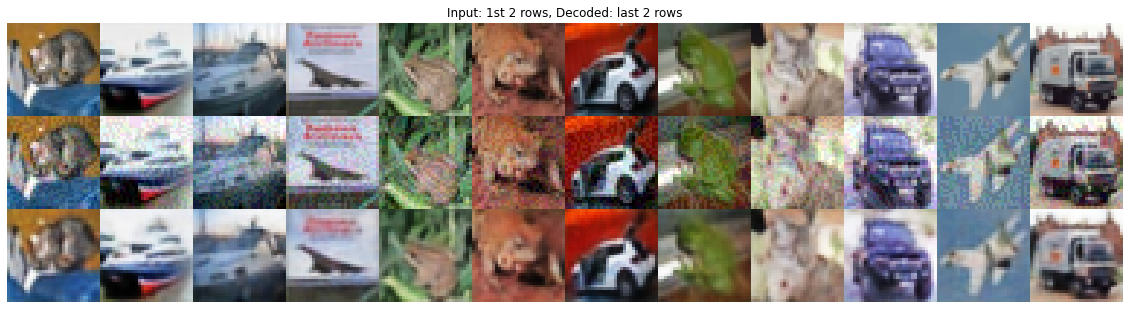

In [69]:
# display the 1st 8 test input and decoded images
imgs = np.concatenate([x_val[:12], x_val_noise[:12], outputs[:12]])
imgs = imgs.reshape((3, 12, 32, 32, 3))

imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure(figsize = (20, 6))
plt.axis('off')
plt.title('Input: 1st 2 rows, Decoded: last 2 rows')
plt.imshow(imgs, interpolation='none')

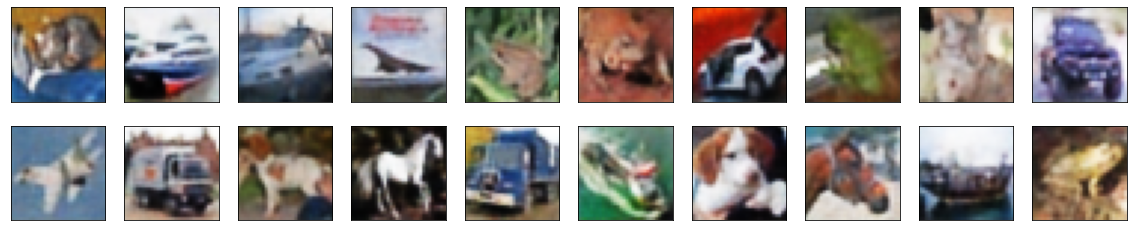

In [63]:
fig = plt.figure(figsize = (20, 4))

for idx in range(20):
  ax = fig.add_subplot(2, 10, idx + 1, xticks = [], yticks = [])
  plt.imshow(np.clip(outputs[idx], 0, 1), cmap = 'gray')